<a href="https://colab.research.google.com/github/rafagutzlaff/PredictionVolumeBTCBR/blob/main/Previs%C3%A3o_Volumes_Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
# importação para uso geral
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# importa biblioteca Yahoo Finance
#!pip install yfinance
import yfinance as yf

# importa biblioteca utilizada para fazer solicitações HTTP
import requests
import csv

#Bibliotecas para utilização das métricas do Sklearn
import sklearn.metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Importação para utilização do modelo de LSTM
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, Dense, Dropout, Masking, Embedding

# Bibliotecas para uso do statsmodels
import statsmodels.api as sm
from scipy import stats

# importações para utilizar o Facebook Prophet
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

# Para utilização na importação de arquivos do Google Drive para o Google Colab
from google.colab import drive
drive.mount('/content/drive')

# bibliotecas para trabalhar offline com a biblioteca
import plotly
import plotly.offline as py
import plotly.graph_objs as go # criará de fato os gráficos
from plotly.offline import plot, iplot
import cufflinks as cf # para conectar o plotly ao pandas
cf.go_offline()
plotly.offline.init_notebook_mode(connected = True)
import plotly.io as pio
pio.renderers.default = 'colab'

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Realiza a importação dos dados de volumes de bitcoins negociados por exchanges brasileiras através da API CointraderMonitor**

In [109]:
# cria o arquivo VolumeBTC_Brasil.csv
#FileCSV = open('dados/VolumeBTCBrasil.csv', 'w', newline='', encoding='utf-8')
FileCSV = open('/content/drive/My Drive/datasets/VolumeBTCBrasil.csv', 'w', newline='', encoding='utf-8')

# cria objeto de gravação
w = csv.writer(FileCSV)
w.writerow(["Date", "Volume BTC"])

# informação do período a ser pesquisado
data_inicial = datetime.strptime('2018-06-01', '%Y-%m-%d')
data_final = datetime.strptime('2021-05-31', '%Y-%m-%d')

# iteração diária para todo o período informado
while (data_inicial <= data_final):
    
    #utiliza a API do cointrademonitor para recuperar as informações diariamente
    response = requests.get('https://cointradermonitor.com/api/pbb/v1/ticker?exchanges=true&time='+
                            data_inicial.strftime('%Y-%m-%d')+'T00:00:00-0300')
    data = response.json()
    
     # escreve os dados no arquivo csv (data e volume)
    w.writerow([data_inicial, data["volume24h"]])
    
     #incrementa em um dia o período a ser pesquisado
    data_inicial = data_inicial + timedelta(days=1)
FileCSV.close()


In [110]:
# para importação via google Drive
df = pd.read_csv('/content/drive/My Drive/datasets/VolumeBTCBrasil.csv')
df.head()

# para importação via Jupyter Notebook
#df = pd.read_csv('dados/VolumeBTCBrasil.csv')
#df.head()

,Date,Volume BTC
0,2018-06-01 00:00:00,217.29
1,2018-06-02 00:00:00,237.19
2,2018-06-03 00:00:00,139.18
3,2018-06-04 00:00:00,145.76
4,2018-06-05 00:00:00,298.21


In [111]:
# mostra a quantidade de linhas do dataset
df.count()

Date          1096
Volume BTC    1096
dtype: int64

**Realiza o download do dataset relativo aos valores do** **bitcoin**


In [112]:
# realiza o download de dados históricos do Bitcoin conforme período informado
df_valores = yf.download("BTC-USD", start="2018-06-01", end="2021-05-31")

# cria o arquivo ValoresBTC_USD
df_valores.to_csv('/content/drive/My Drive/datasets/ValoresBTC_USD.csv')

# Para o Jupyter notebook
#df_valores.to_csv('dados/ValoresBTC_USD.csv')

# mostra a quantidade de linhas do dataset
df_valores.count()

[*********************100%***********************]  1 of 1 completed


Open         1092
High         1092
Low          1092
Close        1092
Adj Close    1092
Volume       1092
dtype: int64

In [114]:
# mostra os primeiros valores
df_valores.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-06-01,7500.700195,7604.729980,7407.339844,7541.450195,7541.450195,4921460224
2018-06-02,7536.720215,7695.830078,7497.259766,7643.450195,7643.450195,4939299840
2018-06-03,7632.089844,7754.890137,7613.040039,7720.250000,7720.250000,4851760128
2018-06-04,7722.529785,7753.819824,7474.040039,7514.470215,7514.470215,4993169920
2018-06-05,7500.899902,7643.229980,7397.000000,7633.759766,7633.759766,4961739776


**Realiza a junção dos dois arquivos obtidos anteriormente para "arquivo_geral.csv"**

In [104]:
# realiza a leitura dos arquivos CSV

# para usar no Jupyter
#df_VolumeBTCBrasil = pd.read_csv('dados/VolumeBTCBrasil.csv',sep=',')
df_VolumeBTCBrasil = pd.read_csv('/content/drive/My Drive/datasets/VolumeBTCBrasil.csv')

# para usar no Jupyter
#df_BTC_USD = pd.read_csv('dados/ValoresBTC_USD.csv',sep=',')
df_BTC_USD = pd.read_csv('/content/drive/My Drive/datasets/ValoresBTC_USD.csv')

# converte os campos Date dos arquivos para formato data
df_VolumeBTCBrasil['Date'] = pd.to_datetime(df_VolumeBTCBrasil['Date'])
df_BTC_USD['Date'] = pd.to_datetime(df_BTC_USD['Date'])

# faz a junção dois dataframe através do campo data
df_geral = pd.merge(df_VolumeBTCBrasil, df_BTC_USD, on='Date', how='outer')


In [115]:
# verifica quais e quantos campos possuem valores nulos
df_geral.isnull().sum()

Date            0
Volume BTC_x    0
Unnamed: 0      0
Volume BTC_y    0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
dtype: int64

In [106]:
# exclui as linhas que possuem valores vazios
df_geral.dropna(inplace=True)

df_geral.isnull().sum()

Date            0
Volume BTC_x    0
Unnamed: 0      0
Volume BTC_y    0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
dtype: int64

In [116]:
# escreve o novo dataset no arquivo CSV
df_geral.to_csv('/content/drive/My Drive/datasets/arquivo_geral.csv', index=False)

# para usar no Jupyter
#df_geral.to_csv("dados/arquivo_geral.csv")

In [117]:
# localiza o maior da coluna Close no dataset
df_geral.loc[df_geral['Close'].idxmax()]

Date            2021-04-13 00:00:00
Volume BTC_x                 840.65
Unnamed: 0                     1047
Volume BTC_y                 840.65
Open                          59890
High                        63742.3
Low                           59870
Close                       63503.5
Adj Close                   63503.5
Volume                  6.99835e+10
Name: 1047, dtype: object

In [118]:
# mostra as principais estatísticas descritivas
df_geral.describe()

,Volume BTC_x,Unnamed: 0,Volume BTC_y,Open,High,Low,Close,Adj Close,Volume
count,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1092.000000,1.092000e+03
mean,850.054304,546.505495,850.054304,13958.166651,14337.051936,13545.027368,13983.375037,13983.375037,2.617242e+10
std,621.365364,316.649866,621.365364,14495.795984,14971.848940,13927.311506,14508.514500,14508.514500,2.283966e+10
min,48.160000,0.000000,48.160000,3236.274658,3275.377930,3191.303467,3236.761719,3236.761719,2.923670e+09
25%,421.645000,272.750000,421.645000,6520.555054,6622.052612,6447.870117,6526.794922,6526.794922,9.003664e+09
50%,746.540000,545.500000,746.540000,8807.428223,8957.514160,8665.192871,8806.394531,8806.394531,2.076196e+10
75%,1106.460000,819.250000,1106.460000,11382.028564,11594.471680,11169.713135,11386.230957,11386.230957,3.616280e+10
max,6237.620000,1095.000000,6237.620000,63523.753906,64863.097656,62208.964844,63503.457031,63503.457031,3.509679e+11


In [127]:
# gráfico dos valores de fechamento do bitcoin, usando o ploty
data = [go.Scatter(x=df_geral.Date, y=df_geral['Close'])]

py.iplot(data)

In [365]:
# convertendo em formato data
df_prophet = df
df_prophet['Date'] = df_prophet.Date.astype('datetime64')

# criando um data frame padrão
df_prophet = df[['Date', 'Volume BTC']]
# verificando as primeiras 5 linhas
df_prophet.head()




,Date,Volume BTC
0,2018-06-01,217.29
1,2018-06-02,237.19
2,2018-06-03,139.18
3,2018-06-04,145.76
4,2018-06-05,298.21


In [366]:
# renomeia as colunas Date e Volume BTC
df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Volume BTC': 'y'})

# Apresenta as primeiras 5 linhas
df_prophet.head()


,ds,y
0,2018-06-01,217.29
1,2018-06-02,237.19
2,2018-06-03,139.18
3,2018-06-04,145.76
4,2018-06-05,298.21


In [367]:
# informa o ajuste da tendência
prior_scale = 0.15

# instancia o modelo e define os parâmetros
m = Prophet(changepoint_prior_scale=prior_scale, interval_width=0.95, daily_seasonality=False)
# realiza o treinamento
m.fit(df_prophet)

In [368]:
# realiza a predição para um período de 180 dias com frequencia diária
future = m.make_future_dataframe(periods=180, freq='D')
forecast = m.predict(future)

# apresenta os 5 últimos valores da predição
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1267,2021-11-23,1505.527614,569.810884,2380.193638
1268,2021-11-24,1466.362558,565.222978,2355.966141
1269,2021-11-25,1550.167789,704.095640,2481.927954
1270,2021-11-26,1545.332611,634.432406,2506.081049
1271,2021-11-27,1423.276486,529.539950,2280.005550


In [369]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2018-06-01,658.838604,-223.724609,1611.595254
1,2018-06-02,501.025520,-420.429632,1435.641730
2,2018-06-03,-55.580358,-911.844967,898.228055
3,2018-06-04,-81.759837,-1017.067973,849.158599
4,2018-06-05,520.495976,-407.373062,1468.232448


***Predição de volume de bitcoins negociados através de LSTM***

In [4]:
df

,Date,Volume BTC,Open,High,Low,Close,Adj Close,Volume
0,2018-06-01,217.29,7500.700195,7604.729980,7407.339844,7541.450195,7541.450195,4.921460e+09
1,2018-06-02,237.19,7536.720215,7695.830078,7497.259766,7643.450195,7643.450195,4.939300e+09
2,2018-06-03,139.18,7632.089844,7754.890137,7613.040039,7720.250000,7720.250000,4.851760e+09
3,2018-06-04,145.76,7722.529785,7753.819824,7474.040039,7514.470215,7514.470215,4.993170e+09
4,2018-06-05,298.21,7500.899902,7643.229980,7397.000000,7633.759766,7633.759766,4.961740e+09
...,...,...,...,...,...,...,...,...
1087,2021-05-27,1522.55,39316.890625,40379.617188,37247.902344,38436.968750,38436.968750,4.321097e+10
1088,2021-05-28,1266.91,38507.082031,38856.968750,34779.039062,35697.605469,35697.605469,5.520019e+10
1089,2021-05-29,2343.44,35684.156250,37234.500000,33693.929688,34616.066406,34616.066406,4.523101e+10
1090,2021-05-30,1108.49,34607.406250,36400.667969,33520.738281,35678.128906,35678.128906,3.164608e+10


## ***Iniciando o treinamento do modelo***

Modelo LSTM

In [5]:
df_lstm = df
df_lstm['Date'] = pd.to_datetime(df_lstm['Date'])

# seta a coluna Date como index
df_lstm.set_index('Date', inplace=True)

# Mantem apenas a coluna Volume BTC que será usada no modelo preditivo
df = df.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)

# cria dois datasets para treino e teste
lstm_treino = df.loc['2018-06-01':'2020-12-31']
lstm_teste = df.loc['2021-01-01':'2021-02-28']


In [6]:
# atribui a coluna "Volume BTC" para o array
lstm_treino_array = lstm_treino.iloc[:,0:1].values

In [7]:
# normaliza os dados utilizando a função MinMaxScaler()
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
lstm_treino_norm = scaler.fit_transform(lstm_treino_array) 
lstm_treino_norm

array([[3.68083606e-02],
       [4.11392681e-02],
       [1.98090048e-02],
       [2.12410335e-02],
       [5.44192667e-02],
       [5.89569260e-02],
       [6.68374365e-02],
       [1.00962376e-01],
       [8.97085452e-02],
       [2.26578278e-02],
       [9.31058047e-02],
       [1.40173410e-01],
       [1.35842503e-01],
       [1.78154816e-01],
       [1.02353054e-01],
       [8.68336061e-02],
       [9.02308657e-03],
       [5.15138589e-03],
       [9.91908385e-02],
       [8.48161432e-02],
       [7.69878648e-02],
       [8.72427572e-02],
       [2.07339474e-01],
       [4.66279859e-02],
       [7.83176057e-02],
       [9.77544571e-02],
       [1.21922662e-01],
       [5.10524758e-02],
       [1.16871387e-01],
       [1.89665454e-01],
       [1.29317849e-02],
       [4.11066230e-02],
       [5.55640191e-02],
       [5.11134132e-02],
       [5.65129013e-02],
       [3.77920642e-02],
       [3.07059162e-02],
       [1.30819521e-02],
       [1.21657149e-03],
       [2.70409673e-02],


In [8]:
#Cria duas listas X_train_lstm, y_train_lstm com 60 timesteps 
timesteps = 60
x_train_lstm = []
y_train_lstm = []
for i in range(timesteps, lstm_treino.shape[0]):
    # Adiciona o timesteps anterior
    x_train_lstm.append(lstm_treino_norm[i-timesteps:i, 0])
    # y_train_lstm será o último volume de fechamento do bitcoin
    y_train_lstm.append(lstm_treino_norm[i, 0]) 
x_train_lstm, y_train_lstm = np.array(x_train_lstm), np.array(y_train_lstm)

In [9]:
# Remodela o dataset de treinamento através da função reshape do numpy
# É passado o array x_train_lstm e a nova estrutura sendo um tupla com as seguintes informações 
# x_train_lstm.shape[0] = batch_size, que é o número de informações de volume do período de treinamento
# x_train_lstm.shape[1] = time_step, que é o número de volumes anteriores
# input_dim = 1, que indica que será usado o Volume de bitcoin negociado
x_train_lstm = np.reshape(x_train_lstm, (x_train_lstm.shape[0], x_train_lstm.shape[1], 1))

In [44]:
#Criação do modelo LSTM utilizando a biblioteca Keras

# Inicialização do modelo
model_rnn = Sequential()

#O parâmetro return_sequences=True indica que a rede terá mais camadas a frente
#O parâmetro Dropout ajuda no ajuste do Overfitting

# Adiciona a primeira camada LSTM com o Dropout 
model_rnn.add(LSTM(units = 128, return_sequences = True, input_shape = (x_train_lstm.shape[1], 1)))
model_rnn.add(Dropout(0.3))

# Adiciona a segunda camada LSTM com o Dropout
model_rnn.add(LSTM(units = 64))
model_rnn.add(Dropout(0.3))

# Adiciona a camada de saída 
model_rnn.add(Dense(1, activation='linear'))

# Compila a RNN, neste caso utilizando o otimizador 'Adam'
model_rnn.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_absolute_error'])

# Faz o treinamento da RNN utilizando o dataset de treinamento
model_rnn.fit(x_train_lstm, y_train_lstm, epochs = 150, batch_size = 32) 

#Mostra o resumo do modelo
model_rnn.summary()

Epoch 1/150
28/28 [==============================] - 8s 102ms/step - loss: 0.0216 - mean_absolute_error: 0.1093
Epoch 2/150
28/28 [==============================] - 3s 103ms/step - loss: 0.0135 - mean_absolute_error: 0.0798
Epoch 3/150
28/28 [==============================] - 3s 103ms/step - loss: 0.0117 - mean_absolute_error: 0.0759
Epoch 4/150
28/28 [==============================] - 3s 104ms/step - loss: 0.0127 - mean_absolute_error: 0.0803
Epoch 5/150
28/28 [==============================] - 3s 103ms/step - loss: 0.0151 - mean_absolute_error: 0.0872
Epoch 6/150
28/28 [==============================] - 3s 104ms/step - loss: 0.0120 - mean_absolute_error: 0.0787
Epoch 7/150
28/28 [==============================] - 3s 103ms/step - loss: 0.0139 - mean_absolute_error: 0.0848
Epoch 8/150
28/28 [==============================] - 3s 102ms/step - loss: 0.0118 - mean_absolute_error: 0.0786
Epoch 9/150
28/28 [==============================] - 3s 105ms/step - loss: 0.0123 - mean_absolute_error:

In [37]:
#Carregamentos dos dados de teste para fazer as predições
# atribui a coluna Volume BTC a lista
lstm_teste_array = lstm_teste.iloc[:,0:1].values 


In [38]:
# Concatena os dados de treinamento e teste, pois os preços de fechamento anteriores não estão no conjunto de teste
combine = pd.concat((lstm_treino['Volume BTC'], lstm_teste['Volume BTC']), axis = 0)

# Tratamento do conjunto de teste considerando os timesteps anteriores
test_inputs = combine[len(combine) - len(lstm_teste) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)

# Normalização dos dados
test_inputs = scaler.transform(test_inputs)

In [39]:
# Predição utilizando os dados de teste
x_test_lstm = []
for i in range(timesteps, lstm_teste.shape[0]+timesteps):
    x_test_lstm.append(test_inputs[i-timesteps:i, 0])
x_test_lstm = np.array(x_test_lstm)
x_test_lstm = np.reshape(x_test_lstm, (x_test_lstm.shape[0], x_test_lstm.shape[1], 1))
predictions_lstm = model_rnn.predict(x_test_lstm)

# Desnormaliza os dados
predictions_lstm = scaler.inverse_transform(predictions_lstm)


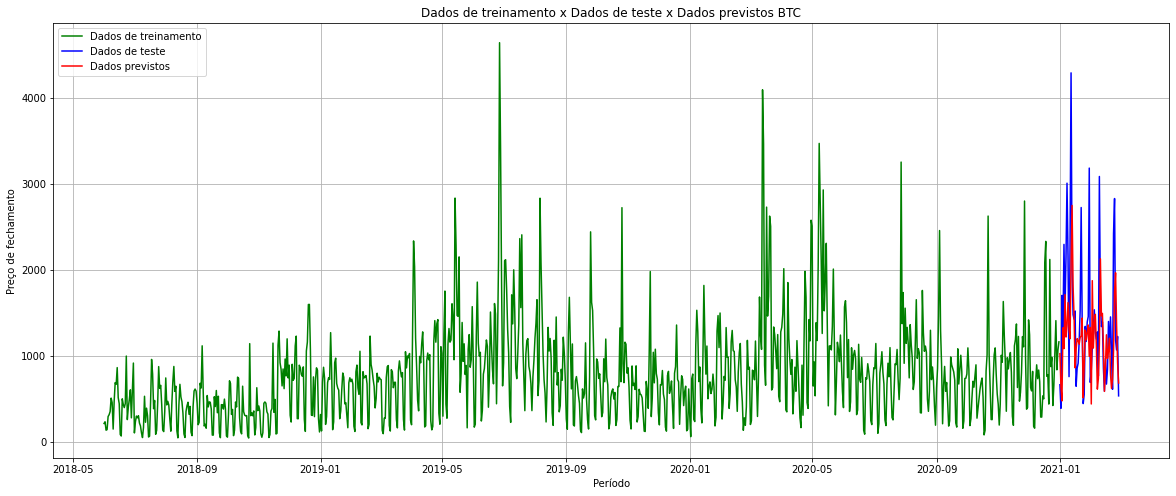

In [40]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(20,8))
plt.plot(lstm_treino.index, lstm_treino['Volume BTC'], color='green', label = 'Dados de treinamento')
plt.plot(lstm_teste.index, lstm_teste['Volume BTC'], color = 'blue', label = 'Dados de teste')
plt.plot(lstm_teste.index, predictions_lstm, color = 'red', label = 'Dados previstos')
plt.title('Dados de treinamento x Dados de teste x Dados previstos BTC')
plt.xlabel('Período')
plt.ylabel('Preço de fechamento')
plt.legend()
plt.grid(True)
plt.show()

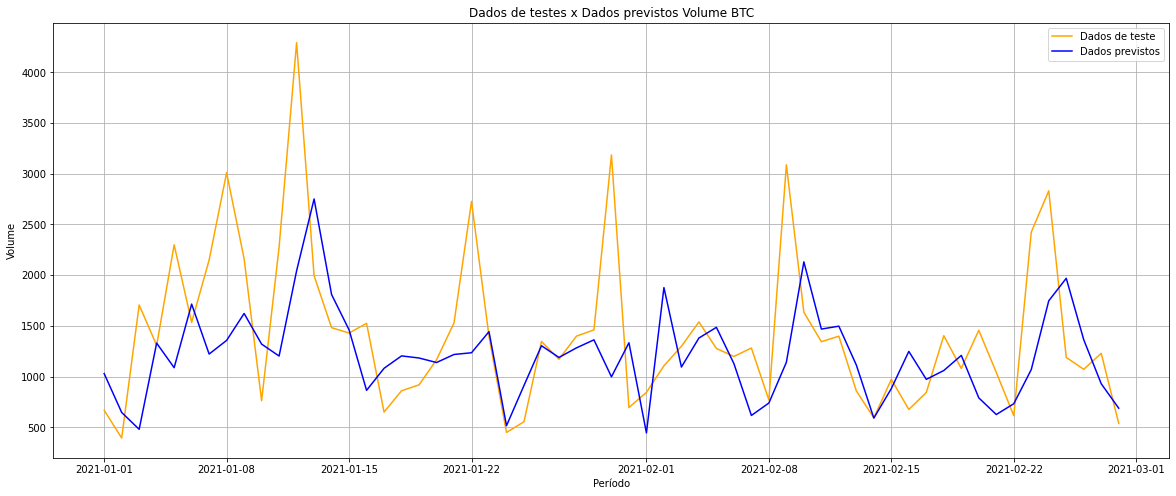

In [41]:
#Plotagem dos dados de teste e dados previstos
plt.figure(figsize=(20,8))
plt.plot(lstm_teste.index, lstm_teste['Volume BTC'], color = 'orange', label = 'Dados de teste')
plt.plot(lstm_teste.index, predictions_lstm, color = 'blue', label = 'Dados previstos')
plt.title('Dados de testes x Dados previstos Volume BTC')
plt.xlabel('Período')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
#Cálculo do erro
print('MAE: ', mean_absolute_error(lstm_teste['Volume BTC'],predictions_lstm))
print('MSE: ', mean_squared_error(lstm_teste['Volume BTC'],predictions_lstm))
print('RMSE: ', np.sqrt(mean_squared_error(lstm_teste['Volume BTC'],predictions_lstm)))


MAE:  514.1912774554754
MSE:  562243.2937067935
RMSE:  749.8288429413698


LSTM utilizando dados futuros

In [26]:
#Teste do modelo treinado para os dados dos meses de Janeiro-Fevereiro-Março/2020
futuro_teste_lstm= df.loc['2021-04-01':'2021-05-31']


In [27]:
# Concatena os dados de treinamento e teste, pois os preços de fechamento anteriores não estão no conjunto de teste
combine = pd.concat((lstm_teste[-timesteps:]['Volume BTC'], futuro_teste_lstm['Volume BTC']), axis = 0)

# Tratamento do conjunto de teste considerando os timesteps anteriores
test_inputs = combine[len(combine) - len(futuro_teste_lstm['Volume BTC']) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)

# Normalização dos dados
test_inputs = scaler.transform(test_inputs)

In [28]:
# Predição utilizando os dados de teste futuro
x_test_lstm = []
for i in range(timesteps, futuro_teste_lstm.shape[0]+timesteps):
    x_test_lstm.append(test_inputs[i-timesteps:i, 0])
x_test_lstm
x_test_lstm = np.array(x_test_lstm, dtype="object")
x_test_lstm = np.reshape(, (x_test_lstm.shape[0], x_test_lstm.shape[1],1))
predictions_lstm = model_rnn.predict(x_test_lstm)

# Desnormaliza os dados
predictions_lstm = scaler.inverse_transform(predictions_lstm)


SyntaxError: ignored

ValueError: ignored

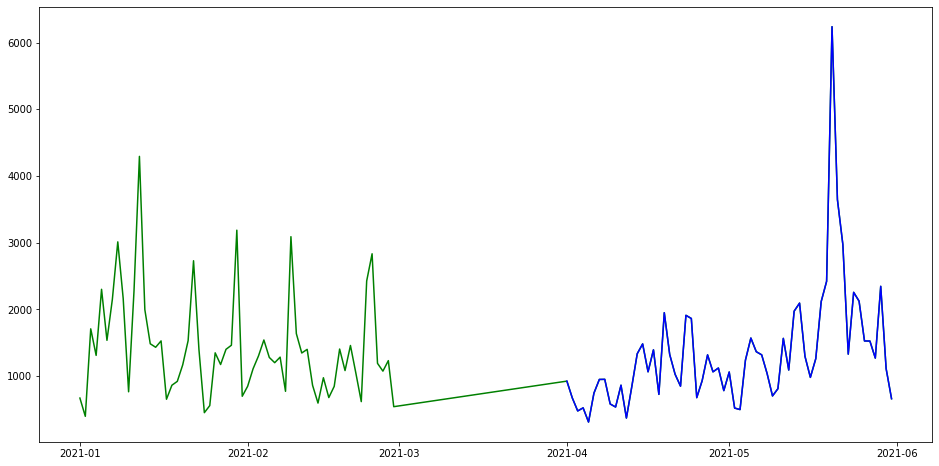

In [398]:
#Plotagem dos dados da janela, dados de teste futuro e dados previstos
plt.figure(figsize=(16,8))
plt.plot(combine.index, combine.values, color = 'green', label = 'Dados da janela')
plt.plot(futuro_teste_lstm.index, futuro_teste_lstm['Volume BTC'], color = 'blue', label = 'Dados de teste futuro')
plt.plot(futuro_teste_lstm.index, predictions_lstm, color = 'red', label = 'Dados previstos')
plt.title('Dados previstos x Dados de teste Volume BTC')
plt.xlabel('Período')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()